# Analysis of results from experimental campaign

This notebook explores and visualize the results on `MicroGridEnv` adopting different strategies. The results are retrieved from some `json`files employed to store the outcome from the testing of each tested algorithm. <br>
The plots shown here have been also used within the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


In [71]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm 
from datetime import datetime
import os
import orjson as json
from pathlib import Path
from collections import OrderedDict

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.4)
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          #"axes.edgecolor" : "black",
          "text.usetex" : True,
          "text.latex.preamble": r'\usepackage{amsmath} \usepackage{amssymb}',
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "font.size": 18
}
plt.rcParams.update(params)

plots_dir = 'examples/single_agent/plots/ijcnn25'
os.makedirs(plots_dir, exist_ok=True)

In [3]:
alg_color = OrderedDict({
    0: plot_colors[0],
    0.01: plot_colors[0],
    0.05: plot_colors[0],
    0.1: plot_colors[0],
    0.25: plot_colors[0],
    0.5: plot_colors[0],
    1: plot_colors[0],
    2: plot_colors[0],
})

alg_markers = OrderedDict({
    0: '.',
    0.01: '.',
    0.05: '.',
    0.1: '.',
    0.25: '.',
    0.5: '.',
    1: '.',
    2: '.',
})

In [19]:
file_names = {
    "CLIP_0": 0,
    "CLIP_0_01": 0.01,
    "CLIP_0_05": 0.05,
    "BEST-IJCNN_2015-2020_deg_new-norm_clip0_1_socmax_gamma0_99_new-market": 0.1,
    "CLIP_0_25": 0.25,
    "CLIP_0_5": 0.5,
    "CLIP_1": 1,
    "CLIP_2": 2,
}

In [20]:
folder = "./logs/"

In [21]:
algs = ['ppo']# 'ppo_fixed_tamb']

In [22]:
exp_folders = list(file_names.keys())

In [23]:
def load_results():
    res = {}
    
    for exp_file in tqdm(exp_folders):
        res[file_names[exp_file]] = []
        results_folder = folder + exp_file + '/results/ppo/'
        tests_files = [f for f in os.listdir(results_folder)]

        for file in tests_files:
            f = open (results_folder + file, "r")
            data = json.loads(f.read())
            res[file_names[exp_file]].append(data)
    return res

In [24]:
res_dict = load_results()

100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.11it/s]


In [25]:
res_dict.keys()

dict_keys([0, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 2])

In [26]:
timestamps = pd.read_csv("ernestogym/ernesto/data/generation/pv_ninja_2019-2020_3kW_test.csv", usecols=['timestamp'])['timestamp'].values.tolist()

In [27]:
timestamps = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in timestamps[1:]]

In [28]:
def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    if not do_not_save:
        save_path = os.path.join(plots_dir, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

In [74]:
do_not_save = False

## PLOTS

In [30]:
# Obejctive function value across all the test experiments throw boxplots
def objective_function(sampling_rate=1, reward_type='pure_reward', test_profile=None):
    data = {}
    fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
    
    profiles = list(range(len(res_dict[0.1])))
    
    for i, alg in enumerate(file_names.values()):
        if test_profile is None:
            trad_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in profiles], axis=0)     
            op_means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in profiles], axis=0)     
            deg_means = np.mean([res_dict[alg][i][reward_type]['r_deg'] for i in profiles], axis=0)
            
            total_reward = np.cumsum(np.sum([trad_means, deg_means], axis=0))
            #total_reward = np.cumsum(np.sum([trad_means, op_means], axis=0))
    
            stds = np.std([res_dict[alg][i][reward_type]['r_trad'] for i in profiles], axis=0)
            ci_trads = 1.96 * stds/np.sqrt(len(profiles))
            stds = np.std([res_dict[alg][i][reward_type]['r_op'] for i in profiles], axis=0)
            ci_op = 1.96 * stds/np.sqrt(len(profiles))
            stds = np.std([res_dict[alg][i][reward_type]['r_deg'] for i in profiles], axis=0)
            ci_deg = 1.96 * stds/np.sqrt(len(profiles))
            
            total_ci = np.cumsum(np.sum([ci_trads, ci_deg], axis=0))
            #total_ci = np.cumsum(np.sum([ci_trads, ci_op], axis=0))

        else:
            trad_rew = res_dict[alg][test_profile][reward_type]['r_trad']
            op_rew = res_dict[alg][test_profile][reward_type]['r_op']
            deg_rew = res_dict[alg][test_profile][reward_type]['r_deg']
            
            total_reward = np.cumsum(np.sum([trad_rew, deg_rew], axis=0))
            #total_reward = np.cumsum(np.sum([trad_rew, op_rew], axis=0))
                
        ax.plot(timestamps[::sampling_rate], total_reward[::sampling_rate], label=str(alg), color=alg_color[alg], marker=alg_markers[alg], markevery=500)
        
        if test_profile is None:
        #if test_profile:
            ax.fill_between(timestamps[::sampling_rate], total_reward[::sampling_rate] + total_ci[::sampling_rate], 
                            total_reward[::sampling_rate] - total_ci[::sampling_rate], 
                            color=alg_color[alg], 
                            alpha=0.1)
        
        ax.set(ylabel=r'$\widehat{\mathcal{R}}_t(\mathfrak{A})$', 
               xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax.legend(loc='lower left', ncols=[5,5])

    savefig(fig, filename='clipping_analysis.pdf')
    savefig(fig, filename='clipping_analysis.png')

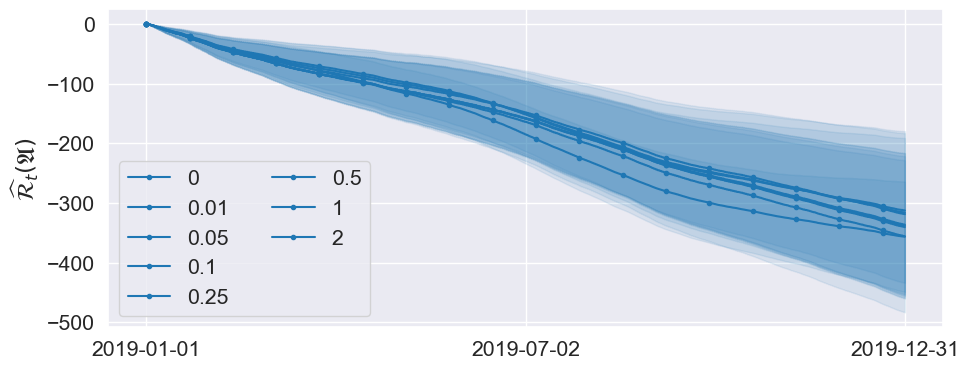

In [31]:
objective_function()

In [77]:
def plot_errorbars(sampling_rate=1, reward_type='pure_reward', test_profile=None):
    fig, ax = plt.subplots(figsize=(11, 4), tight_layout=True)
    patches = []

    profiles = list(range(len(res_dict[0.1])))
    y = []
    ci = []
    
    for i, alg in enumerate(file_names.values()):
        patches.append(Patch(facecolor=alg_color[alg], alpha=0.8, edgecolor=alg_color[alg], label=str(alg)))

        returns = [np.sum(res_dict[alg][i]['pure_reward']['r_trad']) + np.sum(res_dict[alg][i]['pure_reward']['r_deg']) for i in profiles]        
        mean_return = np.mean(returns)

        cis = 1.96 * np.std(returns)/np.sqrt(len(profiles))        
        mean_ci = np.mean(cis) 

        y.append(mean_return)
        ci.append(mean_ci)

        lw = 2 if alg == 0.1 else 1
        ct = 2 if alg == 0.1 else 1
        ax.errorbar(x=i, y=mean_return, yerr=mean_ci, label=str(alg), color=alg_color[alg], ls='', lw=lw, marker=alg_markers[alg], capsize=5, capthick=ct)
    
    ax.plot(range(0, len(list(file_names.values()))), y, color=alg_color[alg], lw=1, ls='--', alpha=0.8)
    ax.set(ylabel=r'$\widehat{R}_\mathcal{T}\,(RL^\star)$', 
           xlabel=r'$\lambda$',
           xticks=range(0, len(list(file_names.values()))), 
           xticklabels=list(file_names.values()))
    #ax.legend(handles=patches, bbox_to_anchor=[0.5,1.2], loc='upper center', ncols=len(file_names))

    savefig(fig, filename='clip_errorbars.pdf')
    savefig(fig, filename='clip_errorbars.png')

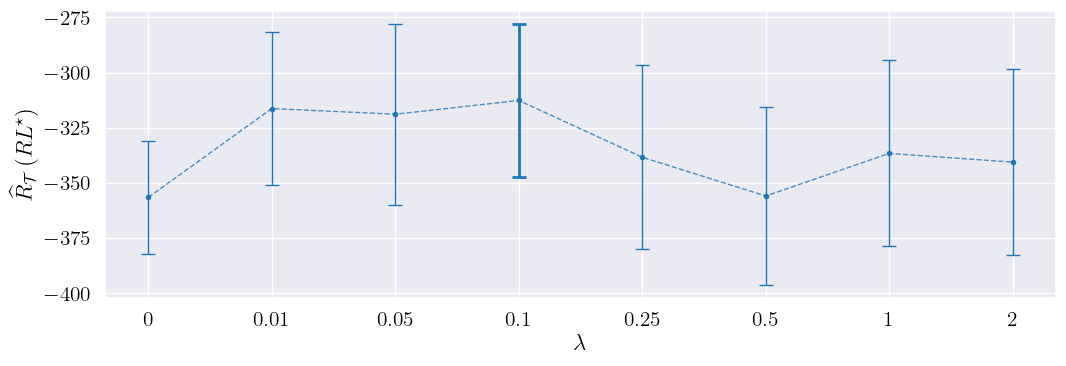

In [78]:
plot_errorbars()